In [1]:
# Basics
import pandas as pd
import numpy as np
import sys 
from pprint import pprint
import pickle

# Skspacy
sys.path.append('../')
from skspacy import SpacyDocFeats, SpacyTokenFilter, SpacyTransformer

# Pipeline / transformation / models
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Model Selection / Grid Search
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
import sklearn.metrics as met
from sklearn.metrics import get_scorer_names

# Plotting
import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
import wordcloud

# MLFlow tracking
import mlflow

## Load Data

In [2]:
path = '../masterDbforNLPAnalysis.xlsx'
df = pd.read_excel(path)
df = df.iloc[:, 1:].set_index('rawCommentId')

In [3]:
df.shape

(2500, 12)

In [4]:
df['Q2'].value_counts(normalize=True)

0    0.8064
1    0.1936
Name: Q2, dtype: float64

## Build Pipeline

In [5]:
mdl = LinearSVC(max_iter=5000) # default is 1000
pipe = Pipeline((
    ('ct', ColumnTransformer((
        ('bowpipe', Pipeline((
            ('tokfilt', SpacyTokenFilter()),
            ('vec', CountVectorizer()),
        )), [0]),
        ('docfeatspipe', Pipeline((
            ('docfeats', SpacyDocFeats(vectors=False)),
            ('scaler', MinMaxScaler())
        )), [0])
    ))),
    ('mdl', mdl)
))

In [6]:
pipe

Pipeline(steps=(('ct',
                 ColumnTransformer(transformers=(('bowpipe',
                                                  Pipeline(steps=(('tokfilt',
                                                                   SpacyTokenFilter()),
                                                                  ('vec',
                                                                   CountVectorizer()))),
                                                  [0]),
                                                 ('docfeatspipe',
                                                  Pipeline(steps=(('docfeats',
                                                                   SpacyDocFeats(vectors=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler()))),
                                                  [0])))),
                ('mdl', LinearSVC(max_iter=5000))))

## Set up Train/Test Sets
We will use Q2 as predicted variable to start for simplicity's sake

In [5]:
TEXT_VAR = 'feedback'
TARGET_VAR = 'Q2'
X = df[TEXT_VAR].values.copy()[:, None].astype('str')
spacytf = SpacyTransformer(procs=1, prog=True)
X = spacytf.fit_transform(X)
y = df[TARGET_VAR].values.copy()

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:07<00:00, 319.92it/s]


Hold aside a protected final validation set

In [6]:
RANDOM_SEED = 43
VAL_SET_SIZE = 0.15
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=VAL_SET_SIZE, random_state=RANDOM_SEED)

In [7]:
print(Xtr.shape, Xval.shape, ytr.shape, yval.shape)

(2125, 1) (375, 1) (2125,) (375,)


## Run Hyperparameter Search

In [10]:
param_grid = {
    'ct__bowpipe__tokfilt__punct': [True, False],
    'ct__bowpipe__tokfilt__pron': [True, False],
    'ct__bowpipe__tokfilt__stop': [True, False],
    'ct__bowpipe__tokfilt__lemma': [True, False],
    'ct__bowpipe__vec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__bowpipe__vec__max_df': [0.90, 0.95, 1.0],
    'ct__bowpipe__vec__min_df': [1, 5, 10, 20],
    'ct__docfeatspipe__docfeats__token_count': [True, False],
    'ct__docfeatspipe__docfeats__pos_counts': [True, False],
    'ct__docfeatspipe__docfeats__ent_counts': [True, False],
    'mdl__C': [1, 0.1, 0.001, 0.0001],
    'mdl__class_weight': ['balanced', None]
}

In [11]:
metrics = ['accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'precision', 'recall']

### 🚀 Run Search
Run 10 searches of 100 fits, then one search of 1000 fits, keeping the top 25 for analysis later 

In [12]:
NUM_ITERS = 100
searcher = RandomizedSearchCV(pipe, param_grid, n_iter=NUM_ITERS, scoring=metrics, 
                              cv=5, random_state=RANDOM_SEED, error_score=np.nan,
                              refit='balanced_accuracy', verbose=0, n_jobs=8)

In [13]:
SAVE_TOP_K_RUNS = 25
mlflow.sklearn.autolog(max_tuning_runs=SAVE_TOP_K_RUNS)

In [14]:
for i in range(10):
    searcher.fit(Xtr, ytr)

2022/06/15 16:20:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '80174e6fab304bf79644e95ef2c49017', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/06/15 16:20:22 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=(('ct',
                 ColumnTransformer(transformers=(('bowpipe',
                                                  Pipeline(steps=(('tokfilt',
                                                                   SpacyTokenFilter()...`
2022/06/15 16:20:22 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'ct__bowpipe__tokfilt__punct': [True, False], 'ct__bowpipe__tokfilt__pron': [True, False], 'ct__bowpipe__tokfilt__stop': [True, False], 'ct__bowpipe__tokfilt__lemma': [True, False], 'ct__bowpipe__vec__ngram_range': [(1, 1), (1, 2), (1, 3)], 'ct__...`
/home/maxspad/ana

In [15]:
searcher.set_params(n_iter=1000)
searcher.fit(Xtr, ytr)

2022/06/15 17:08:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bd8ff874cb9e45a681107029052d0b38', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/06/15 17:08:17 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=(('ct',
                 ColumnTransformer(transformers=(('bowpipe',
                                                  Pipeline(steps=(('tokfilt',
                                                                   SpacyTokenFilter()...`
2022/06/15 17:08:17 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'ct__bowpipe__tokfilt__punct': [True, False], 'ct__bowpipe__tokfilt__pron': [True, False], 'ct__bowpipe__tokfilt__stop': [True, False], 'ct__bowpipe__tokfilt__lemma': [True, False], 'ct__bowpipe__vec__ngram_range': [(1, 1), (1, 2), (1, 3)], 'ct__...`
/home/maxspad/ana

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=(('ct',
                                              ColumnTransformer(transformers=(('bowpipe',
                                                                               Pipeline(steps=(('tokfilt',
                                                                                                SpacyTokenFilter()),
                                                                                               ('vec',
                                                                                                CountVectorizer()))),
                                                                               [0]),
                                                                              ('docfeatspipe',
                                                                               Pipeline(steps=(('docfeats',
                                                                                                SpacyDocFeats(vectors=False)),
                                                                                               ('scaler',
                                                                                                MinMaxScaler()))),
                                                                               [0])))),
                                             ('mdl',
                                              LinearSVC(max_iter=5000)))),
                   n_iter=1000, n_jobs=8,
                   param...
                                        'ct__docfeatspipe__docfeats__ent_counts': [True,
                                                                                   False],
                                        'ct__docfeatspipe__docfeats__pos_counts': [True,
                                                                                   False],
                                        'ct__docfeatspipe__docfeats__token_count': [True,
                                                                                    False],
                                        'mdl__C': [1, 0.1, 0.001, 0.0001],
                                        'mdl__class_weight': ['balanced',
                                                              None]},
                   random_state=43, refit='balanced_accuracy',
                   scoring=['accuracy', 'balanced_accuracy', 'roc_auc', 'f1',
                            'precision', 'recall'])

## Evaluate Models and Hyperparams
### Load Best Model from Hyperparam Search

In [8]:
TARGET_METRIC = 'metrics.best_cv_score'
runs = mlflow.search_runs()
runs = runs.dropna(subset=TARGET_METRIC).sort_values(TARGET_METRIC, ascending=False)
top_run = runs.iloc[0,:]
top_run_id = top_run['run_id']
top_run_model_path = f'mlruns/0/{top_run_id}/artifacts/best_estimator/model.pkl'
with open(top_run_model_path, 'rb') as f:
    mdl = pickle.load(f)
# logged_model = f'runs:/{top_run_id}/best_estimator'
# loaded_model = mlflow.pyfunc.load_model(logged_model)

print(f'Best model is {top_run_id}')
print(f'Best model score ({TARGET_METRIC}) is {top_run[TARGET_METRIC]}')

Best model is ed07d512ea354bb1942f53417ad988c0
Best model score (metrics.best_cv_score) is 0.7838309855645089


### Evaluate Model on Validation Set

In [9]:
yval_pred = mdl.predict(Xval)

In [10]:
import sklearn.metrics as mets

In [11]:
def get_metrics(y, p):
    return {
        'balanced_accuracy': mets.balanced_accuracy_score(y, p),
        'accuracy': mets.accuracy_score(y, p),
        'roc_auc': mets.roc_auc_score(y, p),
        'f1': mets.f1_score(y, p),
        'precision': mets.precision_score(y, p),
        'recall': mets.recall_score(y, p),
        'confusion': mets.confusion_matrix(y, p),
        'clfrep': mets.classification_report(y, p)
    }

In [20]:
pprint(mdl.get_params())

{'ct': ColumnTransformer(transformers=(('bowpipe',
                                 Pipeline(steps=(('tokfilt',
                                                  SpacyTokenFilter(punct=False)),
                                                 ('vec',
                                                  CountVectorizer(max_df=0.9,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2))))),
                                 [0]),
                                ('docfeatspipe',
                                 Pipeline(steps=(('docfeats',
                                                  SpacyDocFeats(ent_counts=False,
                                                                vectors=False)),
                                                 ('scaler', MinMaxScaler()))),
                                 [

In [12]:
pprint(get_metrics(yval, yval_pred))

{'accuracy': 0.8373333333333334,
 'balanced_accuracy': 0.7794781438074121,
 'clfrep': '              precision    recall  f1-score   support\n'
           '\n'
           '           0       0.90      0.89      0.89       287\n'
           '           1       0.65      0.67      0.66        88\n'
           '\n'
           '    accuracy                           0.84       375\n'
           '   macro avg       0.77      0.78      0.78       375\n'
           'weighted avg       0.84      0.84      0.84       375\n',
 'confusion': array([[255,  32],
       [ 29,  59]]),
 'f1': 0.6592178770949721,
 'precision': 0.6483516483516484,
 'recall': 0.6704545454545454,
 'roc_auc': 0.7794781438074121}


In [21]:
print(get_metrics(yval, yval_pred)['confusion'])

[[255  32]
 [ 29  59]]


In [22]:
# ppv = tp / (tp + fp)
ppv = 255 / (255 + 29)
print(ppv)

0.897887323943662


In [13]:
def get_feat_weights_df(mdl):
    coefs = mdl[-1].coef_.copy().flatten()
    feats = mdl[:-1].get_feature_names_out()
    return pd.DataFrame({
        'feature': [f.split('__')[1] for f in feats],
        'coef': coefs,
        'coef.abs': np.abs(coefs),
        'positive': [c >= 0 for c in coefs]
    })

feat_weights = get_feat_weights_df(mdl)
feat_weights = feat_weights.sort_values('coef')
feat_weights = feat_weights.set_index('feature')

In [14]:
feat_weights.head(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
excellent,-0.115045,0.115045
management,-0.071909,0.071909
able to,-0.064640,0.064640
able,-0.052878,0.052878
assessment,-0.051671,0.051671
nan,-0.048896,0.048896
required,-0.041122,0.041122
up,-0.039984,0.039984
thorough,-0.038969,0.038969


In [15]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
is,0.042793,0.042793
head,0.043512,0.043512
remember to,0.044202,0.044202
some,0.044687,0.044687
prompting,0.047665,0.047665
continue to,0.048585,0.048585
can,0.048755,0.048755
of,0.054926,0.054926
in,0.055486,0.055486


### Wordcloud -  All Words

Red = weighted toward Q2 = 0 

Green = weighted toward Q2 = 1

In [16]:
def color_func(word, *args, **kwargs):
    if not feat_weights.loc[word, 'positive']: return (186, 60, 60)
    else: return (60, 186, 72)

(-0.5, 799.5, 399.5, -0.5)

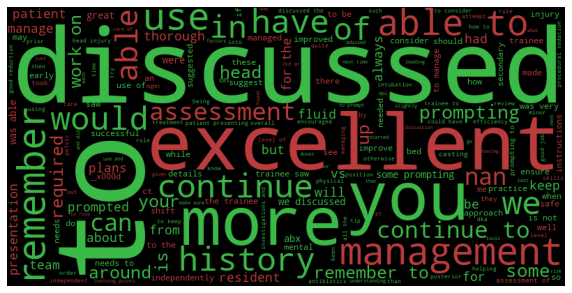

In [17]:
fw_for_wc = feat_weights[['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, color_func=color_func)
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted toward Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

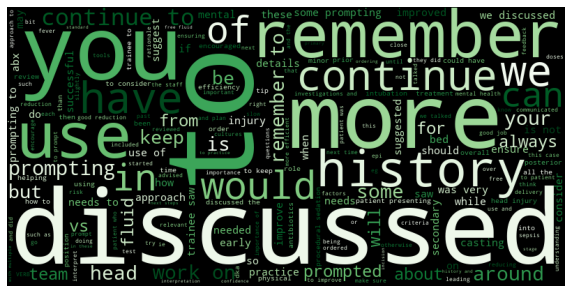

In [18]:
fw_for_wc = feat_weights[feat_weights['coef'] >= 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Greens'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted AGAINST Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

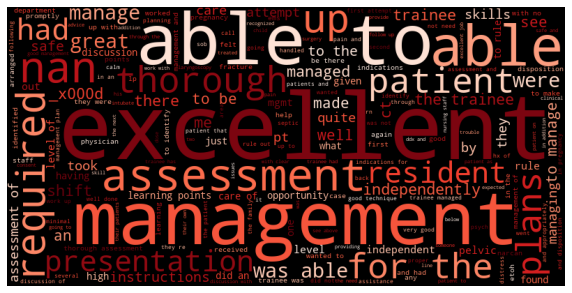

In [19]:
fw_for_wc = feat_weights[feat_weights['coef'] < 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Reds'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

---

In [25]:
from sklearn.metrics import get_scorer_names
print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'top_k_accuracy', 